In [1]:
from pathlib import Path
import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import skimage.io as io
from skimage.color import rgb2ycbcr, ycbcr2rgb

# from skimage.filters import gaussian
from scipy.ndimage import median_filter
from skimage.metrics import peak_signal_noise_ratio
from scipy.signal import convolve2d
# from pdb import set_trace

# from bilateral import bilateral2d
# from fspecial import fspecial_gaussian_2d
# from nlm import nonlocalmeans

from scipy.interpolate import interp2d
import scipy
scipy.__version__

'1.7.3'

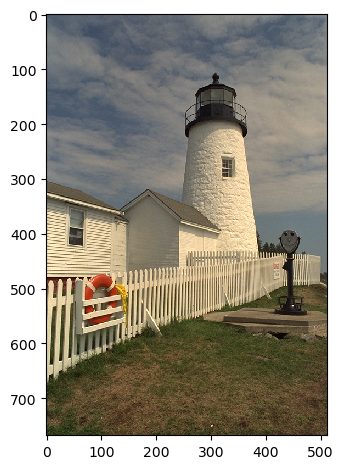

In [2]:
true_lighthouse = io.imread('lighthouse.png').astype(float)/255
# true_lighthouse = true_lighthouse[400:500, 300:400, :]

def compare_pnsr(test_img):
    psnr = peak_signal_noise_ratio(true_lighthouse, test_img)
    print('psnr ', psnr)
    return psnr

io.imshow(true_lighthouse)

1.0
(768, 512)


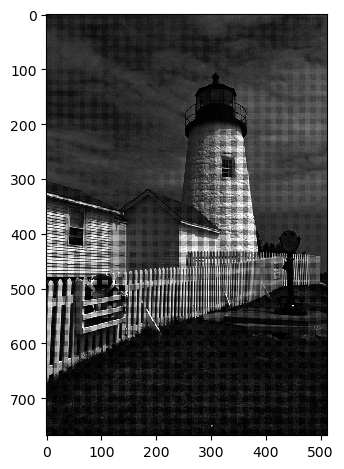

In [3]:
raw_lighthouse = io.imread('lighthouse_RAW_noisy_sigma0.01.png').astype(float)/255
raw_lighthouse_colorcoded = io.imread('lighthouse_RAW_colorcoded.png').astype(float)/255
bayer = raw_lighthouse_colorcoded[0:2, 0:2, :]

# raw_lighthouse = raw_lighthouse[400:500, 300:400]
print(np.amax(raw_lighthouse))
io.imshow(raw_lighthouse)
print(np.shape(raw_lighthouse))

In [4]:
%%time
# even_indices = lambda n: [i for i in range(0, n, 2)]
even_indices = lambda n: np.arange(0, n, 2)
odd_indices = lambda n: np.add(even_indices(n), 1)


def cartesian_product(x, y):
#     return cartesian = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    return [[x0, y0] for x0 in x for y0 in y]

def interp(img, col_row_indexer):
    shape = np.shape(img)
    num_rows, num_cols = shape
    print(shape)
    x_range = np.arange(num_cols)
    y_range = np.arange(num_rows)
    xx, yy = np.meshgrid(x_range, y_range)
    cartesian = cartesian_product(col_row_indexer(num_cols), col_row_indexer(num_rows))
    y = [xy[1] for xy in cartesian]
    x = [xy[0] for xy in cartesian]
    for i in range(len(cartesian)):
        z = [img[y[i], x[i]] for i in range(len(cartesian))]
#     print('max z', np.amax(z))
    interpolator = interp2d(x, y, z)
    interp = interpolator(x_range, y_range)
#     print(np.shape(interp))
    return np.clip(interp, 0., 1.)

def roll_average_green(img):
    # Remove red and blue mosiac values
    green_channel = np.copy(img)
    shape = np.shape(img)
    num_rows, num_cols = shape
    red_indices = cartesian_product(even_indices(num_cols), even_indices(num_rows))
    blue_indices = cartesian_product(odd_indices(num_cols), odd_indices(num_rows))
    for i in range(len(red_indices)):
        c, r = red_indices[i]
        green_channel[r, c] = 0.
    for i in range(len(blue_indices)):
        c, r = blue_indices[i]
        green_channel[r, c] = 0.
    # Shift in four directions to get average, include the original green channel to keep orginally captured values
    roll_right = np.roll(green_channel, shift=1, axis=0)
    roll_left = np.roll(green_channel, shift=-1, axis=0)
    roll_up = np.roll(green_channel, shift=-1, axis=1)
    roll_down = np.roll(green_channel, shift=1, axis=1)
    return np.add(np.average([roll_right, roll_left, roll_down, roll_up], axis=0), green_channel)

def demosaic_linear(img):
    shape = np.shape(img)
#     print(shape)
    num_rows, num_cols = shape
    x = range(0, num_cols)
    y = range(0, num_rows)
    #     Interpolate red channels
    red_channel = interp(img, even_indices)
#     print('max red', np.amax(red_channel))
    #     Interpolate blue channels
    blue_channel = interp(img, odd_indices)
#     print('max blue', np.amax(blue_channel))
    #     Interpolate gree
    green_channel = roll_average_green(img)
#     print('max green', np.amax(green_channel))
    #     Stack together
    R = red_channel
    G = green_channel
    B = blue_channel
    rgb_lighthouse = np.stack([R, G, B], axis=2)
    return rgb_lighthouse

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


In [5]:
def normalize_kernel(kernel):
#     return kernel
    kernel = np.array(kernel)
    min_val = np.amin(kernel)
    shift_kernel = np.add(kernel, np.abs(min_val))
    total_coeffs = np.sum(shift_kernel)
    normalized = np.divide(shift_kernel, total_coeffs)
#     print(np.sum(normalized))
    return normalized

G_at_R = normalize_kernel(
    [[0, 0, -1, 0, 0],
     [0, 0, 2, 0, 0],
     [-1, 2, 4, 2, -1],
     [0, 0, 2, 0, 0],
     [0, 0, -1, 0, 0]])
G_at_B = G_at_R
# R at G in R row, B col
R_at_G_rb = normalize_kernel(
    [[0, 0, 1/2, 0, 0],
     [0, -1, 0, -1, 0],
     [-1, 4, 5, 4, -1],
     [0, -1, 0, -1, 0],
     [0, 0, 1/2, 0, 0]])
R_at_G_br = np.transpose(R_at_G_rb)
R_at_B_bb = normalize_kernel(
    [[0, 0, -3/2, 0, 0],
     [0, 2, 0, 2, 0],
     [-3/2, 0, 6, 0, -3/2],
     [0, 2, 0, 2, 0],
     [0, 0, -3/2, 0, 0]])
# 
B_at_G_br = normalize_kernel(
    [[0, 0, 1/2, 0, 0],
     [0, -1, 0, -1, 0],
     [-1, 4, 5, 4, -1],
     [0, -1, 0, -1, 0],
     [0, 0, 1/2, 0, 0]])
B_at_G_rb = np.transpose(B_at_G_br)
B_at_R_rr = R_at_B_bb

def is_odd(num):
    return bool(num % 2 != 0)

def demosaic_highquality(img):
    shape = np.shape(img)
    num_rows, num_cols = shape
    img_convs = {
        'G_at_R': convolve2d(img, G_at_R, boundary='symm', mode='same'),
        'G_at_B': convolve2d(img, G_at_B, boundary='symm', mode='same'),
        'R_at_G_rb': convolve2d(img, R_at_G_rb, boundary='symm', mode='same'),
        'R_at_G_br': convolve2d(img, R_at_G_br, boundary='symm', mode='same'),
        'R_at_B_bb': convolve2d(img, R_at_B_bb, boundary='symm', mode='same'),
        'B_at_G_br': convolve2d(img, B_at_G_br, boundary='symm', mode='same'),
        'B_at_G_rb': convolve2d(img, B_at_G_rb, boundary='symm', mode='same'),
        'B_at_R_rr': convolve2d(img, B_at_R_rr, boundary='symm', mode='same')
    }
    img_rgb = np.zeros((num_rows, num_cols, 3), dtype='float')
    #     green channel
    img_green = np.copy(img)
    for r in range(num_rows):
        for c in range(num_cols):
            if (is_odd(r) and is_odd(c)): # G_at_B
                img_green[r,c] = img_convs['G_at_B'][r, c]
            elif (not is_odd(r) and not is_odd(c)): # G_at_R
                img_green[r,c] = img_convs['G_at_R'][r, c]
            else: 
                pass
    img_red = np.copy(img)
    for r in range(num_rows):
        for c in range(num_cols):
            if (is_odd(r) and is_odd(c)): # R_at_B
                img_red[r,c] = img_convs['R_at_B_bb'][r, c]
            elif (not is_odd(r) and is_odd(c)): # R_at_G_rb
                img_red[r,c] = img_convs['R_at_G_rb'][r, c]
            elif (is_odd(r) and not is_odd(c)): # R_at_G_br
                img_red[r,c] = img_convs['R_at_G_br'][r, c]
            else:
                pass
    img_blue = np.copy(img)
    for r in range(num_rows):
        for c in range(num_cols):
            if (not is_odd(r) and is_odd(c)): # R_at_B
                img_blue[r,c] = img_convs['B_at_G_rb'][r, c]
            elif (is_odd(r) and not is_odd(c)): # R_at_G_rb
                img_blue[r,c] = img_convs['B_at_G_br'][r, c]
            elif (not is_odd(r) and not is_odd(c)): # R_at_G_br
                img_blue[r,c] = img_convs['B_at_R_rr'][r, c]
            else:
                pass
    img_rgb[:, :, 0] = img_red
    img_rgb[:, :, 1] = img_green
    img_rgb[:, :, 2] = img_blue
    
    return img_rgb

In [6]:
#     Scales image values to [0,1] and applies gamma correction
def clip_channels(img):
    shape = np.shape(img)
    num_rows, num_cols, num_channels = shape
    #     Normalize each channel
    img_normalize = np.zeros(shape)
    for ch in range(num_channels):
        img_channel = img[:, :, ch]
        normalized = np.clip(img_channel, 0., 1.)
        img_normalize[:, :, ch] = normalized
    return img_normalize

# def normalize_channels(img, clip=False):
#     shape = np.shape(img)
#     num_rows, num_cols, num_channels = shape
#     #     Normalize each channel
#     img_normalize = np.zeros(shape)
#     for ch in range(num_channels):
#         img_channel = img[:, :, ch]
#         if clip:
#             normalized = np.clip(img_channel, 0., 1.)
#         else:
#             ch_max = np.amax(img_channel)
#             ch_min = np.amin(img_channel)
#             normalized = np.divide(np.subtract(img_channel, ch_min), np.subtract(ch_max, ch_min))
#         img_normalize[:, :, ch] = normalized
#     return img_normalize

def gamma_correct(img):
    return np.power(img, 1./2.2)

# image is RGB 
# thres between [16, 240] (128 midpoint)
def median_chrominance(img):
    shape = np.shape(img)
#     print(np.amin(img), np.amax(img))
    img_ycbcr = rgb2ycbcr(img)
#     print(img_ycbcr.dtype, img.dtype)
#     print(np.shape(img_ycbcr), np.amax(img_ycbcr), np.amin(img_ycbcr))
    img_y = img_ycbcr[:, :, 0]
    img_cb = img_ycbcr[:, :, 1]
    img_cr = img_ycbcr[:, :, 2]
#     print(np.amax(img_cb), np.amin(img_cb))
    
    img_median = img_ycbcr
    img_median[:, :, 1] = median_filter(img_cb, 5)
    img_median[:, :, 2] = median_filter(img_cr, 5)
    return ycbcr2rgb(img_median)

(768, 512)


/opt/anaconda3/envs/csc2529/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=1,1 nx,ny=178,160 m=98304 fp=524.600252 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


(768, 512)


/opt/anaconda3/envs/csc2529/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=266,375 m=98304 fp=0.569387 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


psnr  11.802208076702891
CPU times: user 1h 58min 47s, sys: 13.9 s, total: 1h 59min 1s
Wall time: 1h 59min 3s


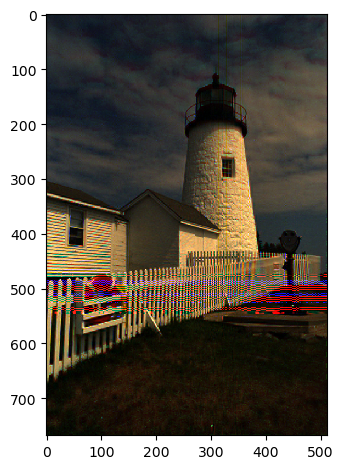

In [7]:
%%time
lininterp_lighthouse = demosaic_linear(raw_lighthouse)
compare_pnsr(lininterp_lighthouse)
io.imshow(lininterp_lighthouse)

psnr  12.185476171034086
CPU times: user 867 ms, sys: 6.62 ms, total: 874 ms
Wall time: 874 ms


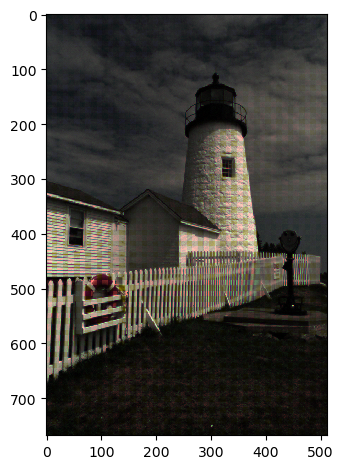

In [8]:
%%time
hqinterp_lighthouse = demosaic_highquality(raw_lighthouse)
compare_pnsr(hqinterp_lighthouse)
io.imshow(hqinterp_lighthouse)

psnr  20.155267944521704
CPU times: user 49.5 ms, sys: 1.51 ms, total: 51.1 ms
Wall time: 49.6 ms


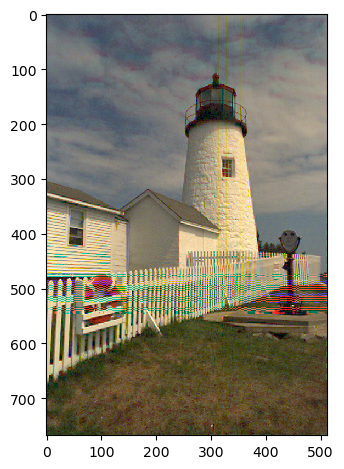

In [9]:
%%time
gamma_lininterp_lighthouse = gamma_correct(lininterp_lighthouse)
compare_pnsr(gamma_lininterp_lighthouse)
io.imshow(gamma_lininterp_lighthouse)

psnr  23.47640393771872
CPU times: user 49.8 ms, sys: 1.14 ms, total: 50.9 ms
Wall time: 49.8 ms


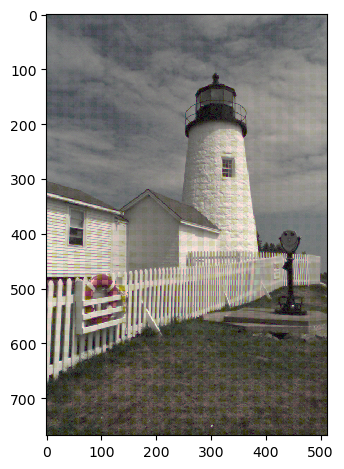

In [10]:
%%time
gamma_hqinterp_lighthouse = gamma_correct(hqinterp_lighthouse)
compare_pnsr(gamma_hqinterp_lighthouse)
io.imshow(gamma_hqinterp_lighthouse)

psnr  24.270941990477866
CPU times: user 302 ms, sys: 3.9 ms, total: 306 ms
Wall time: 308 ms


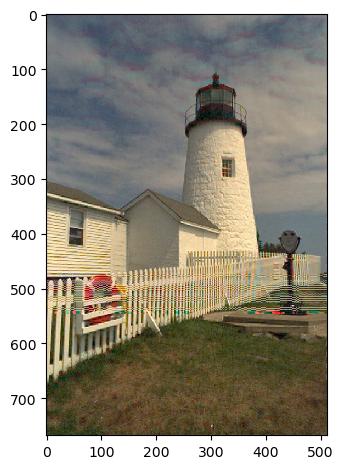

In [11]:
%%time
gamma_chrom_lininterp_lighthouse = gamma_correct(clip_channels(median_chrominance(lininterp_lighthouse)))
compare_pnsr(gamma_chrom_lininterp_lighthouse)
io.imshow(gamma_chrom_lininterp_lighthouse)

psnr  24.337057017126153
CPU times: user 311 ms, sys: 3.1 ms, total: 314 ms
Wall time: 313 ms


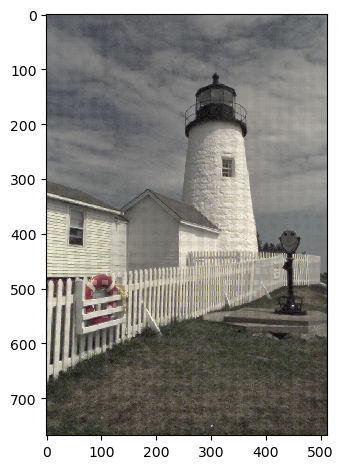

In [12]:
%%time
gamma_chrom_hqinterp_lighthouse = gamma_correct(clip_channels(median_chrominance(hqinterp_lighthouse)))
compare_pnsr(gamma_chrom_hqinterp_lighthouse)
io.imshow(gamma_chrom_hqinterp_lighthouse)